<a href="https://colab.research.google.com/github/dcpatton/NLP/blob/master/civil_comments_dnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Objective

The comments in this dataset come from an archive of the Civil Comments platform, a commenting plugin for independent news sites. These public comments were created from 2015 - 2017 and appeared on approximately 50 English-language news sites across the world. When Civil Comments shut down in 2017, they chose to make the public comments available in a lasting open archive to enable future research. The original data, published on figshare, includes the public comment text, some associated metadata such as article IDs, timestamps and commenter-generated "civility" labels, but does not include user ids. Jigsaw extended this dataset by adding additional labels for toxicity and identity mentions. 

I am going to predict the toxicity level (valued from 0.0 to 1.0). I am using a text embeddings based on feed-forward Neural-Net Language Models (nnlm) with pre-built OOV and pre-trained on a English Google News corpus.

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_hub as hub
import random

seed = 52
tf.random.set_seed(seed)
random.seed(seed)

tf.__version__

'2.3.0'

# Get The Data

In [2]:
train_ds, val_ds, test_ds = tfds.load('civil_comments', split=['train', 'validation', 'test'], shuffle_files=True, as_supervised=True, try_gcs=True)

/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Shuffling and writing examples to /root/tensorflow_datasets/civil_comments/0.9.0.incompleteRD64X0/civil_comments-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/civil_comments/0.9.0.incompleteRD64X0/civil_comments-validation.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/civil_comments/0.9.0.incompleteRD64X0/civil_comments-test.tfrecord


Dataset civil_comments downloaded and prepared to /root/tensorflow_datasets/civil_comments/0.9.0. Subsequent calls will reuse this data.


In [3]:
train_ds = train_ds.batch(32).prefetch(tf.data.experimental.AUTOTUNE)
val_ds = val_ds.batch(64).prefetch(tf.data.experimental.AUTOTUNE)
test_ds = test_ds.batch(64).prefetch(tf.data.experimental.AUTOTUNE)

# The Model

In [4]:
from tensorflow.keras.regularizers import L2

tf.keras.backend.clear_session()

# hub_layer = hub.KerasLayer("https://tfhub.dev/google/nnlm-en-dim50/2", input_shape=[], dtype=tf.string)
# hub_layer = hub.KerasLayer("https://tfhub.dev/google/nnlm-en-dim50-with-normalization/2", input_shape=[], dtype=tf.string)
# hub_layer = hub.KerasLayer("https://tfhub.dev/google/nnlm-en-dim128/2", input_shape=[], dtype=tf.string)
hub_layer = hub.KerasLayer("https://tfhub.dev/google/nnlm-en-dim128-with-normalization/2", input_shape=[], dtype=tf.string)

model = tf.keras.Sequential()
model.add(hub_layer)
# model.add(tf.keras.layers.Dropout(0.25))
model.add(tf.keras.layers.Dense(512, activation='relu'))
# model.add(tf.keras.layers.Dropout(0.25))
model.add(tf.keras.layers.Dense(512, activation='relu'))
# model.add(tf.keras.layers.Dropout(0.25))
model.add(tf.keras.layers.Dense(512, activation='relu'))
# model.add(tf.keras.layers.Dropout(0.25))
model.add(tf.keras.layers.Dense(512, activation='relu'))
# model.add(tf.keras.layers.Dropout(0.25))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 128)               124642688 
_________________________________________________________________
dense (Dense)                (None, 512)               66048     
_________________________________________________________________
dense_1 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_2 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_3 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 513       
Total params: 125,497,217
Trainable params: 854,529
Non-trainable params: 124,642,688
____________________________________

In [5]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), # default learning rate
              loss='mse', 
              metrics=['mae'])

# Training

In [6]:
es = tf.keras.callbacks.EarlyStopping(patience=10, verbose=1, restore_best_weights=True)

history = model.fit(train_ds, epochs=200, verbose=1, validation_data=val_ds, callbacks=[es])

Epoch 1/200
56403/56403 [==============================] - 342s 6ms/step - loss: 0.0419 - mae: 0.1044 - val_loss: 0.0264 - val_mae: 0.1064
Epoch 2/200
56403/56403 [==============================] - 347s 6ms/step - loss: 0.0258 - mae: 0.1041 - val_loss: 0.0254 - val_mae: 0.1013
Epoch 3/200
56403/56403 [==============================] - 352s 6ms/step - loss: 0.0251 - mae: 0.1023 - val_loss: 0.0251 - val_mae: 0.1011
Epoch 4/200
56403/56403 [==============================] - 348s 6ms/step - loss: 0.0247 - mae: 0.1013 - val_loss: 0.0250 - val_mae: 0.0990
Epoch 5/200
56403/56403 [==============================] - 346s 6ms/step - loss: 0.0243 - mae: 0.1004 - val_loss: 0.0250 - val_mae: 0.0989
Epoch 6/200
56403/56403 [==============================] - 348s 6ms/step - loss: 0.0240 - mae: 0.0996 - val_loss: 0.0249 - val_mae: 0.0977
Epoch 7/200
56403/56403 [==============================] - 347s 6ms/step - loss: 0.0238 - mae: 0.0990 - val_loss: 0.0248 - val_mae: 0.0991
Epoch 8/200
56403/56403 [==

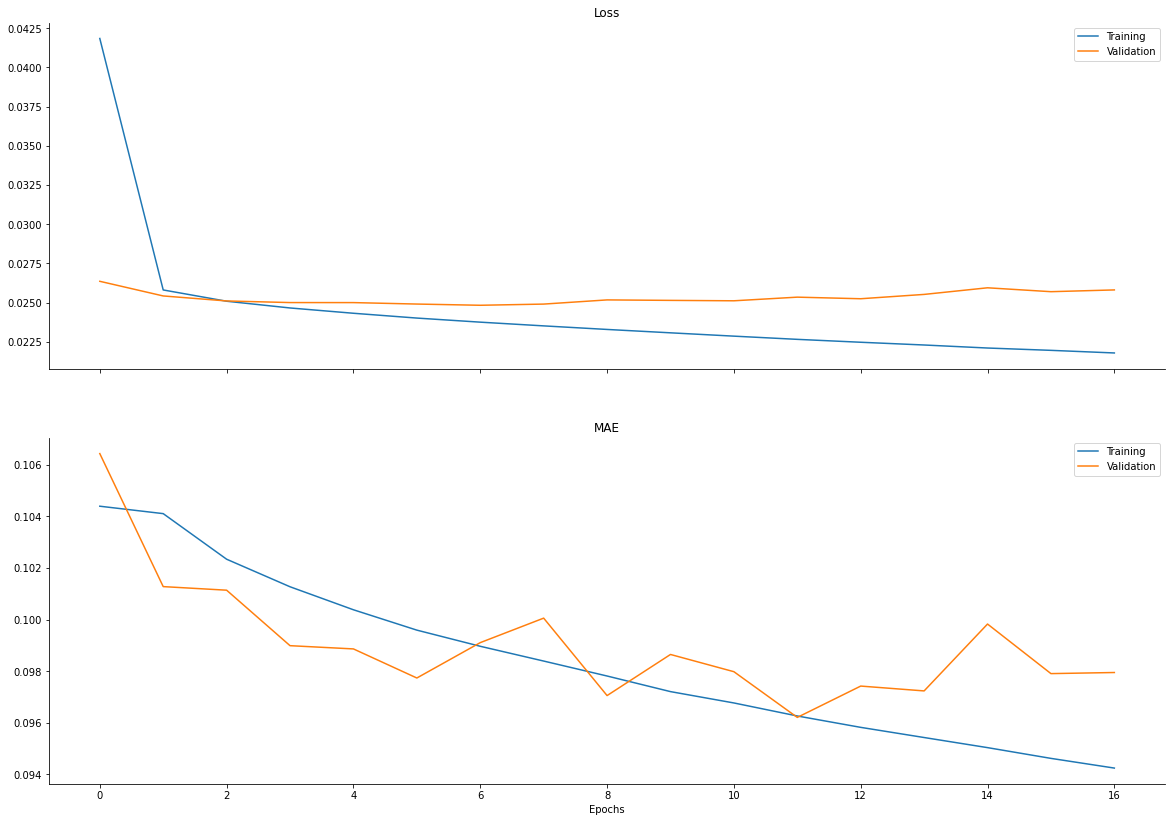

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

history = history.history

fig, (ax1, ax2) = plt.subplots(2, 1, sharex='col', figsize=(20, 14))

ax1.plot(history['loss'], label='Training')
ax1.plot(history['val_loss'], label='Validation')
ax1.legend(loc='best')
ax1.set_title('Loss')

ax2.plot(history['mae'], label='Training')
ax2.plot(history['val_mae'], label='Validation')
ax2.legend(loc='best')
ax2.set_title('MAE')

plt.xlabel('Epochs')
sns.despine()
plt.show()

## Fine Tuning

In [8]:
model.layers[0].trainable=True
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 128)               124642688 
_________________________________________________________________
dense (Dense)                (None, 512)               66048     
_________________________________________________________________
dense_1 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_2 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_3 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 513       
Total params: 125,497,217
Trainable params: 125,497,217
Non-trainable params: 0
__________________________________________

In [9]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-6), # default learning rate
              loss='mse', 
              metrics=['mae'])

In [10]:
history = model.fit(train_ds, epochs=20, verbose=1, validation_data=val_ds, callbacks=[es])

Epoch 1/20
56403/56403 [==============================] - 1392s 25ms/step - loss: 0.0229 - mae: 0.0971 - val_loss: 0.0238 - val_mae: 0.0988
Epoch 2/20
56403/56403 [==============================] - 1396s 25ms/step - loss: 0.0220 - mae: 0.0954 - val_loss: 0.0231 - val_mae: 0.0969
Epoch 3/20
56403/56403 [==============================] - 1397s 25ms/step - loss: 0.0213 - mae: 0.0935 - val_loss: 0.0224 - val_mae: 0.0953
Epoch 4/20
56403/56403 [==============================] - 1394s 25ms/step - loss: 0.0207 - mae: 0.0919 - val_loss: 0.0219 - val_mae: 0.0938
Epoch 5/20
56403/56403 [==============================] - 1391s 25ms/step - loss: 0.0202 - mae: 0.0905 - val_loss: 0.0214 - val_mae: 0.0925
Epoch 6/20
56403/56403 [==============================] - 1401s 25ms/step - loss: 0.0197 - mae: 0.0893 - val_loss: 0.0209 - val_mae: 0.0915
Epoch 7/20
56403/56403 [==============================] - 1392s 25ms/step - loss: 0.0193 - mae: 0.0882 - val_loss: 0.0205 - val_mae: 0.0904
Epoch 8/20
56403/564

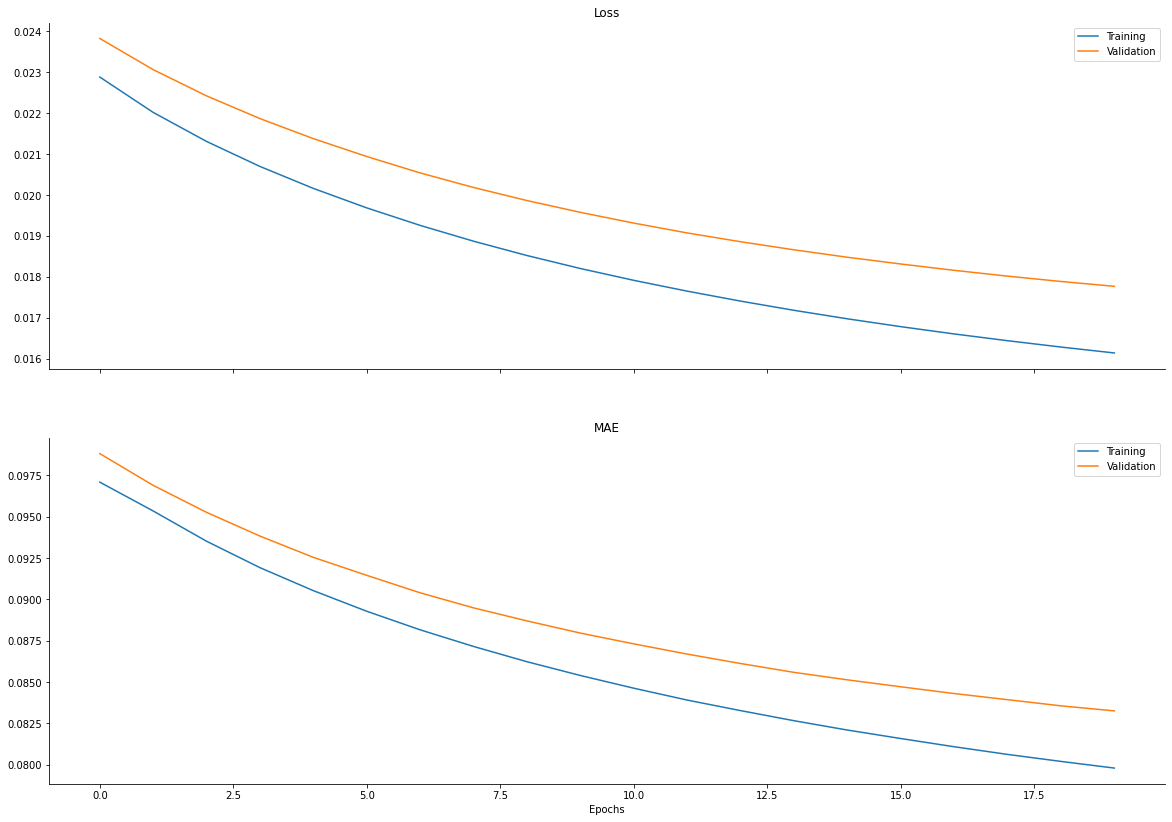

In [11]:
history = history.history

fig, (ax1, ax2) = plt.subplots(2, 1, sharex='col', figsize=(20, 14))

ax1.plot(history['loss'], label='Training')
ax1.plot(history['val_loss'], label='Validation')
ax1.legend(loc='best')
ax1.set_title('Loss')

ax2.plot(history['mae'], label='Training')
ax2.plot(history['val_mae'], label='Validation')
ax2.legend(loc='best')
ax2.set_title('MAE')

plt.xlabel('Epochs')
sns.despine()
plt.show()

# Evaluation

In [12]:
model.evaluate(test_ds, verbose=1)

1521/1521 [==============================] - 11s 7ms/step - loss: 0.0180 - mae: 0.0837


[0.017955254763364792, 0.08368293941020966]

* nnlm-en-dim50:                      loss: 0.0332 - mae: 0.1242
* additional DenseNN:                 loss: 0.0327 - mae: 0.1232
* nnlm-en-dim50-with-normalization:   loss: 0.0296 - mae: 0.1158
* nnlm-en-dim128-with-normalization:  loss: 0.0251 - mae: 0.1011
* l2(0.01):                           loss: 0.0389 - mae: 0.1439
* batchnorm:                          loss: 0.0253 - mae: 0.1055
* more batchnorm:                     loss: 0.0248 - mae: 0.1025
* Dropout(0.5):                       loss: 0.0277 - mae: 0.1122
* Dropout(0.25):                      loss: 0.0270 - mae: 0.1150

* Fine tuning (20 iterations):        **loss: 0.0180 - mae: 0.0837**                   


In [13]:
import numpy as np
y_true = []
for element in test_ds:
  y_true.extend(element[1].numpy().tolist())

predictions = model.predict(test_ds)

In [14]:
y_pred = predictions.flatten()
y_pred = y_pred.tolist()
m = tf.keras.metrics.AUC()
m.update_state(y_true, y_pred)
print('AUCROC = ' + str(m.result().numpy()))

AUCROC = 0.8123454
